In [68]:
import json


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, AdaBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score


from tensorflow import keras
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data_path = '/kaggle/input/nab/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv'

file_key = 'realKnownCause/ambient_temperature_system_failure.csv'
labels_path = "/kaggle/input/nab-labels-file/combined_labels.json"
windows_path = "/kaggle/input/nab-labels-file/combined_windows.json"

In [37]:
df = pd.read_csv(data_path, parse_dates=['timestamp'])
df.head(3)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7267 non-null   datetime64[ns]
 1   value      7267 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.7 KB


In [39]:
df['label'] = np.ones(len(df), dtype=int)
df.head()

,timestamp,value,label
0,2013-07-04 00:00:00,69.880835,1
1,2013-07-04 01:00:00,71.220227,1
2,2013-07-04 02:00:00,70.877805,1
3,2013-07-04 03:00:00,68.959400,1
4,2013-07-04 04:00:00,69.283551,1


In [40]:
with open(labels_path, "r") as f:
    labels_data = json.load(f)

with open(windows_path, "r") as f:
    windows_data = json.load(f)

label_points = labels_data.get(file_key, [])
label_windows = windows_data.get(file_key, [])

In [41]:
label_points, label_windows

(['2013-12-22 20:00:00', '2014-04-13 09:00:00'],
 [['2013-12-15 07:00:00.000000', '2013-12-30 09:00:00.000000'],
  ['2014-03-29 15:00:00.000000', '2014-04-20 22:00:00.000000']])

In [42]:
# For specific label
for i in label_points:
    df.loc[df['timestamp']==pd.to_datetime(i), 'label'] = -1
    print(df[df['timestamp']==pd.to_datetime(i)])

# For window of label
for start, end in label_windows:
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    mask = (df["timestamp"] >= start) & (df["timestamp"] <= end)
    df.loc[mask, "label"] = -1

               timestamp      value  label
3721 2013-12-22 20:00:00  86.204189     -1
               timestamp      value  label
6180 2014-04-13 09:00:00  57.458406     -1


<Axes: xlabel='timestamp', ylabel='value'>

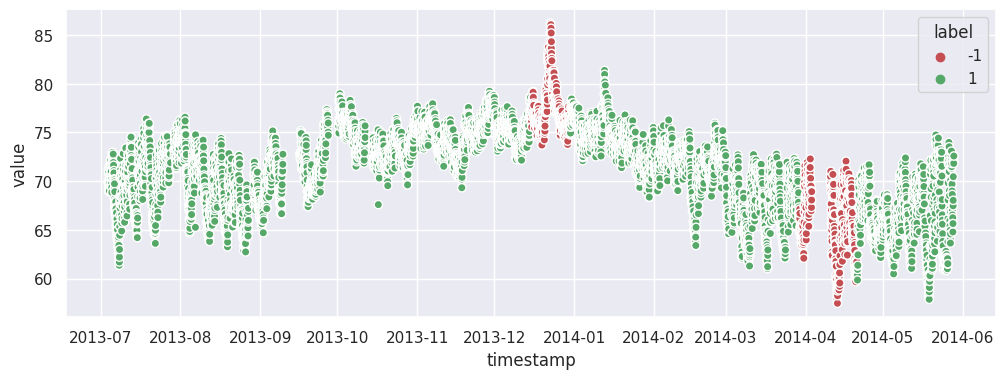

In [43]:
sns.set(rc={'figure.figsize':(12, 4)})
sns.scatterplot(data=df, x="timestamp", y="value", hue='label', linewidth=1, palette={-1:'r', 1:'g'})

In [44]:
X = df[['value']].values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
class AnomalyMethods:

    def __init__(self):
        self.name = None
        self.age = None
    
    def using_knn(self, data, model, n_neighbors=3, percentile=95, predictions=True):
        model.fit(data)

        # Compute distances
        distances, indices = model.kneighbors(data, n_neighbors=n_neighbors)

        # Compute anomaly scores
        anomaly_scores = distances.mean(axis=1)

        # Set threshold
        threshold = np.percentile(anomaly_scores, percentile)

        labels=None
        if predictions:
            labels = np.where(anomaly_scores > threshold, -1, 1) # -1: anomaly, 1: inlier
            
        return model, labels
    
    def using_pca(self, data, model, variance_explained=0.95, predictions=True):
        pca = PCA(n_components=variance_explained)  # Retain 95% variance if variance_explained=0.95
        X_pca = pca.fit_transform(data)

        # Reconstruct data
        projected_data = pca.inverse_transform(X_pca)

        # Compute reconstruction error
        reconstruction_error = np.mean((data - projected_data) ** 2, axis=1)

        # Anomaly threshold (95th percentile)
        threshold = np.percentile(reconstruction_error, 95)

        labels = None
        if predictions:
            labels = np.where(reconstruction_error > threshold, -1, 1) # -1: anomaly, 1: inlier
        
        return pca, labels
    
    def using_adaboost(self, X_train, Y_train, X_test, model, predictions=True):
        model.fit(X_train, Y_train)

        labels = None
        if predictions:
            lables = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of anomaly class
        
        return model, labels

In [75]:
results = {'Method':[], 'Precision':[], 'Recall':[], 'F1-Score':[], 'Supervision':[]}

am = AnomalyMethods()

# 1.KNN
model = NearestNeighbors()
knn, knn_y_pred = am.using_knn(X_scaled, model)

knn_precision = precision_score(df['label'], knn_y_pred, pos_label=-1)
knn_recall = recall_score(df['label'], knn_y_pred, pos_label=-1)
knn_f1 = f1_score(df['label'], knn_y_pred, pos_label=-1)
print(f'Method: KNN, Precision: {knn_precision}, Recall: {knn_recall}, F1: {knn_f1}')

results['Method'].append('KNN')
results['Precision'].append(knn_precision)
results['Recall'].append(knn_recall)
results['F1-Score'].append(knn_f1)
results['Supervision'].append('Unsupervised')


# 2.Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_y_pred = lof.fit_predict(X_scaled)

lof_precision = precision_score(df['label'], lof_y_pred, pos_label=-1)
lof_recall = recall_score(df['label'], lof_y_pred, pos_label=-1)
lof_f1 = f1_score(df['label'], lof_y_pred, pos_label=-1)
print(f'Method: LOF, Precision: {lof_precision}, Recall: {lof_recall}, F1: {lof_f1}')

results['Method'].append('Local Outlier Factor')
results['Precision'].append(lof_precision)
results['Recall'].append(lof_recall)
results['F1-Score'].append(lof_f1)
results['Supervision'].append('Unsupervised')


# 3.One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm_y_pred = ocsvm.fit_predict(X_scaled)

ocsvm_precision = precision_score(df['label'], ocsvm_y_pred, pos_label=-1)
ocsvm_recall = recall_score(df['label'], ocsvm_y_pred, pos_label=-1)
ocsvm_f1 = f1_score(df['label'], ocsvm_y_pred, pos_label=-1)
print(f'Method: One Class SVM, Precision: {ocsvm_precision}, Recall: {ocsvm_recall}, F1: {ocsvm_f1}')

results['Method'].append('One Class SVM')
results['Precision'].append(ocsvm_precision)
results['Recall'].append(ocsvm_recall)
results['F1-Score'].append(ocsvm_f1)
results['Supervision'].append('Unsupervised')


# 4.Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso_y_pred = iso.fit_predict(X_scaled)

iso_precision = precision_score(df['label'], iso_y_pred, pos_label=-1)
iso_recall = recall_score(df['label'], iso_y_pred, pos_label=-1)
iso_f1 = f1_score(df['label'], iso_y_pred, pos_label=-1)
print(f'Method: Isolation Forest, Precision: {iso_precision}, Recall: {iso_recall}, F1: {iso_f1}')

results['Method'].append('Isolation Forest')
results['Precision'].append(iso_precision)
results['Recall'].append(iso_recall)
results['F1-Score'].append(iso_f1)
results['Supervision'].append('Unsupervised')


# 5.Elliptic Envelope
ell = EllipticEnvelope(contamination=0.05)
ell_y_pred = ell.fit_predict(X_scaled)

ell_precision = precision_score(df['label'], ell_y_pred, pos_label=-1)
ell_recall = recall_score(df['label'], ell_y_pred, pos_label=-1)
ell_f1 = f1_score(df['label'], ell_y_pred, pos_label=-1)
print(f'Method: Elliptic Envelope, Precision: {ell_precision}, Recall: {ell_recall}, F1: {ell_f1}')

results['Method'].append('Elliptic Envelope')
results['Precision'].append(ell_precision)
results['Recall'].append(ell_recall)
results['F1-Score'].append(ell_f1)
results['Supervision'].append('Unsupervised')


# 6.PCA reconstruction error
pca = PCA(n_components=1)
pca, pca_y_pred = am.using_pca(X_scaled, pca)

pca_precision = precision_score(df['label'], pca_y_pred, pos_label=-1)
pca_recall = recall_score(df['label'], pca_y_pred, pos_label=-1)
pca_f1 = f1_score(df['label'], pca_y_pred, pos_label=-1)
print(f'Method: PCA, Precision: {pca_precision}, Recall: {pca_recall}, F1: {pca_f1}')

results['Method'].append('PCA')
results['Precision'].append(pca_precision)
results['Recall'].append(pca_recall)
results['F1-Score'].append(pca_f1)
results['Supervision'].append('Unsupervised')


# 7.Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
scores = gmm.score_samples(X_scaled)
threshold = np.percentile(scores, 5)
gmm_y_pred = np.where(scores < threshold, -1, 1)

gmm_precision = precision_score(df['label'], gmm_y_pred, pos_label=-1)
gmm_recall = recall_score(df['label'], gmm_y_pred, pos_label=-1)
gmm_f1 = f1_score(df['label'], gmm_y_pred, pos_label=-1)
print(f'Method: GMM, Precision: {gmm_precision}, Recall: {gmm_recall}, F1: {gmm_f1}')

results['Method'].append('GMM')
results['Precision'].append(gmm_precision)
results['Recall'].append(gmm_recall)
results['F1-Score'].append(gmm_f1)
results['Supervision'].append('Unsupervised')

# 8.K-Means distance method
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
distances = np.min(np.abs(X_scaled - kmeans.cluster_centers_[labels]), axis=1)
threshold = np.percentile(distances, 95)
kmeans_y_pred = np.where(distances > threshold, -1, 1)

kmeans_precision = precision_score(df['label'], kmeans_y_pred, pos_label=-1)
kmeans_recall = recall_score(df['label'], kmeans_y_pred, pos_label=-1)
kmeans_f1 = f1_score(df['label'], kmeans_y_pred, pos_label=-1)
print(f'Method: K-Means, Precision: {kmeans_precision}, Recall: {kmeans_recall}, F1: {kmeans_f1}')

results['Method'].append('K Means')
results['Precision'].append(kmeans_precision)
results['Recall'].append(kmeans_recall)
results['F1-Score'].append(kmeans_f1)
results['Supervision'].append('Unsupervised')


# 9.DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=75)
labels = dbscan.fit_predict(X_scaled)
DBSCAN_y_pred = np.where(labels == -1, -1, 1)

DBSCAN_precision = precision_score(df['label'], DBSCAN_y_pred, pos_label=-1)
DBSCAN_recall = recall_score(df['label'], DBSCAN_y_pred, pos_label=-1)
DBSCAN_f1 = f1_score(df['label'], DBSCAN_y_pred, pos_label=-1)
print(f'Method: DBSCAN, Precision: {DBSCAN_precision}, Recall: {DBSCAN_recall}, F1: {DBSCAN_f1}')

results['Method'].append('DBSCAN')
results['Precision'].append(DBSCAN_precision)
results['Recall'].append(DBSCAN_recall)
results['F1-Score'].append(DBSCAN_f1)
results['Supervision'].append('Unsupervised')


# 10.Autoencoder
input_dim = X_scaled.shape[1]
autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(input_dim, activation=None)
])
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=16, verbose=0)
recon = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - recon), axis=1)
threshold = np.percentile(mse, 95)
auto_y_pred = np.where(mse > threshold, -1, 1)

auto_precision = precision_score(df['label'], auto_y_pred, pos_label=-1)
auto_recall = recall_score(df['label'], auto_y_pred, pos_label=-1)
auto_f1 = f1_score(df['label'], auto_y_pred, pos_label=-1)
print(f'Method: Autoencoder, Precision: {auto_precision}, Recall: {auto_recall}, F1: {auto_f1}')

results['Method'].append('Autoencoder')
results['Precision'].append(auto_precision)
results['Recall'].append(auto_recall)
results['F1-Score'].append(auto_f1)
results['Supervision'].append('Unsupervised')


# 11.AdaBoost
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['label'], test_size=0.3, random_state=42)
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

ada_precision = precision_score(y_test, y_pred_ada, pos_label=-1)
ada_recall = recall_score(y_test, y_pred_ada, pos_label=-1)
ada_f1 = f1_score(y_test, y_pred_ada, pos_label=-1)
print(f'Method: AdaBoost, Precision: {ada_precision}, Recall: {ada_recall}, F1: {ada_f1}')

results['Method'].append('AdaBoost')
results['Precision'].append(ada_precision)
results['Recall'].append(ada_recall)
results['F1-Score'].append(ada_f1)
results['Supervision'].append('Semi-supervised')

Method: KNN, Precision: 0.40384615384615385, Recall: 0.2024793388429752, F1: 0.26972477064220185
Method: LOF, Precision: 0.17857142857142858, Recall: 0.08953168044077135, F1: 0.11926605504587158
Method: One Class SVM, Precision: 0.26344086021505375, Recall: 0.2024793388429752, F1: 0.22897196261682243
Method: Isolation Forest, Precision: 0.45604395604395603, Recall: 0.22865013774104684, F1: 0.3045871559633027
Method: Elliptic Envelope, Precision: 0.3434065934065934, Recall: 0.1721763085399449, F1: 0.22935779816513757
Method: PCA, Precision: 0.37790697674418605, Recall: 0.08953168044077135, F1: 0.1447661469933185
Method: GMM, Precision: 0.4368131868131868, Recall: 0.2190082644628099, F1: 0.291743119266055
Method: K-Means, Precision: 0.44505494505494503, Recall: 0.2231404958677686, F1: 0.29724770642201837
Method: DBSCAN, Precision: 0.9166666666666666, Recall: 0.06060606060606061, F1: 0.11369509043927647
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Method: Autoencoder, Precision: 0.48626373626

In [76]:
metrics_df = pd.DataFrame(results)
metrics_df

,Method,Precision,Recall,F1-Score,Supervision
0,KNN,0.403846,0.202479,0.269725,Unsupervised
1,Local Outlier Factor,0.178571,0.089532,0.119266,Unsupervised
2,One Class SVM,0.263441,0.202479,0.228972,Unsupervised
3,Isolation Forest,0.456044,0.228650,0.304587,Unsupervised
4,Elliptic Envelope,0.343407,0.172176,0.229358,Unsupervised
5,PCA,0.377907,0.089532,0.144766,Unsupervised
6,GMM,0.436813,0.219008,0.291743,Unsupervised
7,K Means,0.445055,0.223140,0.297248,Unsupervised
8,DBSCAN,0.916667,0.060606,0.113695,Unsupervised
9,Autoencoder,0.486264,0.243802,0.324771,Unsupervised


In [77]:
results

{'Method': ['KNN',
  'Local Outlier Factor',
  'One Class SVM',
  'Isolation Forest',
  'Elliptic Envelope',
  'PCA',
  'GMM',
  'K Means',
  'DBSCAN',
  'Autoencoder',
  'AdaBoost'],
 'Precision': [0.40384615384615385,
  0.17857142857142858,
  0.26344086021505375,
  0.45604395604395603,
  0.3434065934065934,
  0.37790697674418605,
  0.4368131868131868,
  0.44505494505494503,
  0.9166666666666666,
  0.48626373626373626,
  0.6153846153846154],
 'Recall': [0.2024793388429752,
  0.08953168044077135,
  0.2024793388429752,
  0.22865013774104684,
  0.1721763085399449,
  0.08953168044077135,
  0.2190082644628099,
  0.2231404958677686,
  0.06060606060606061,
  0.24380165289256198,
  0.14035087719298245],
 'F1-Score': [0.26972477064220185,
  0.11926605504587158,
  0.22897196261682243,
  0.3045871559633027,
  0.22935779816513757,
  0.1447661469933185,
  0.291743119266055,
  0.29724770642201837,
  0.11369509043927647,
  0.3247706422018349,
  0.22857142857142856],
 'Supervision': ['Unsupervised',


In [78]:
metrics_df.to_csv('temperature_results.csv')